In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

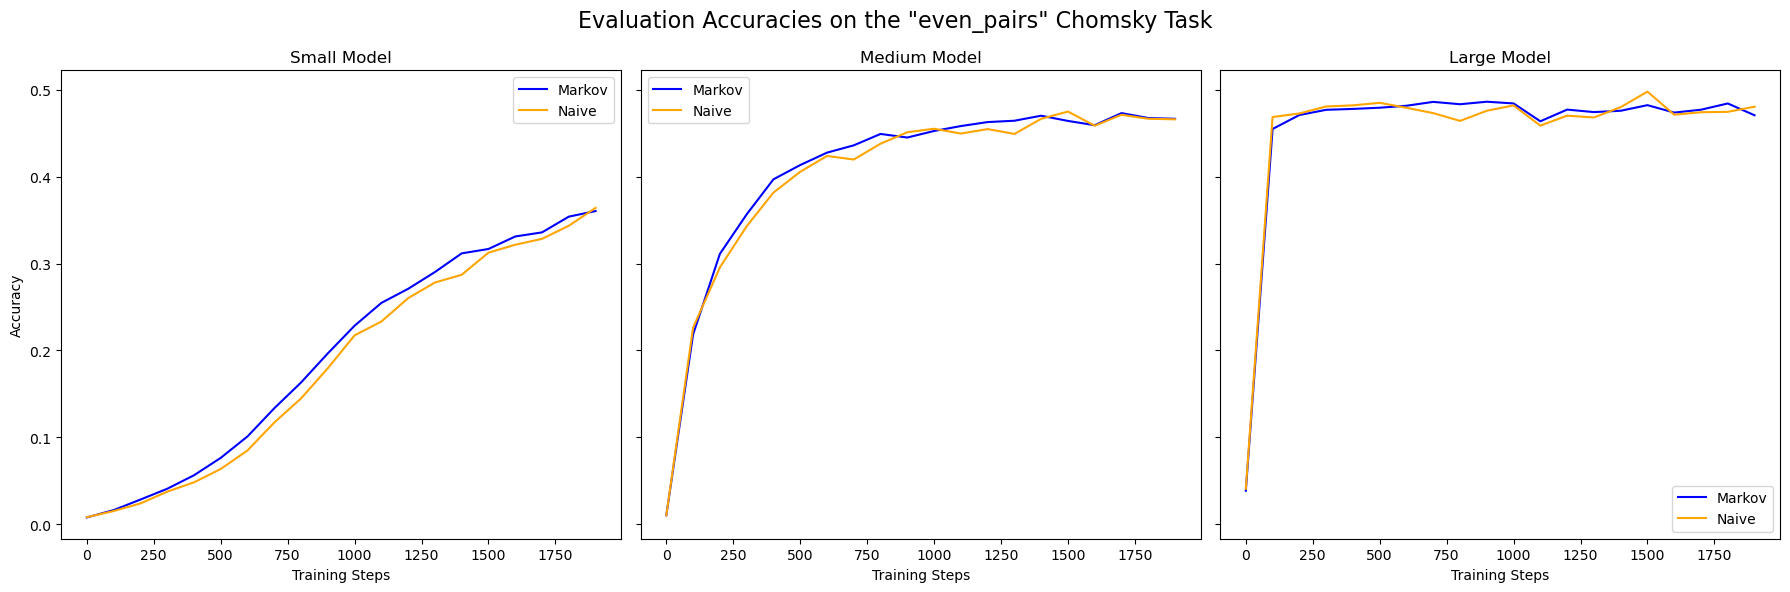

In [6]:
# Generate Eval Accuracies Graph - Merged by model size
model_sizes = [
    "small",
    "medium",
    "large",
]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Evaluation Accuracies on the "even_pairs" Chomsky Task', fontsize=16)

for i, model_size in enumerate(model_sizes):
    ax = axs[i]
    
    # Plot both markov and original on the same subplot
    for use_markov in [True, False]:
        suffix = "markov" if use_markov else "original"
        label_prefix = "Markov" if use_markov else "Naive"
        
        results = pd.read_csv(f'artifacts/metrics_{suffix}_transformer_{model_size}.csv')
        eval_final_accs = results['eval_final_accs']
        
        # Plot raw data
        log_skip_size = 100
        ax.plot(
                [i * log_skip_size for i in range(len(eval_final_accs))],
                eval_final_accs, 
                color='blue' if use_markov else 'orange',
                label=f'{label_prefix}')
        
        # # Plot rolling average
        # eval_final_accs_rolling = pd.Series(eval_final_accs).rolling(window=10).mean()
        # ax.plot(eval_final_accs_rolling, 
        #         linewidth=2,
        #         color='blue' if use_markov else 'orange',
        #         label=f'{label_prefix} Rolling Avg')
    
    ax.set_title(f'{model_size.capitalize()} Model')
    ax.set_xlabel('Training Steps')
    ax.legend()
    
    if i == 0:
        ax.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

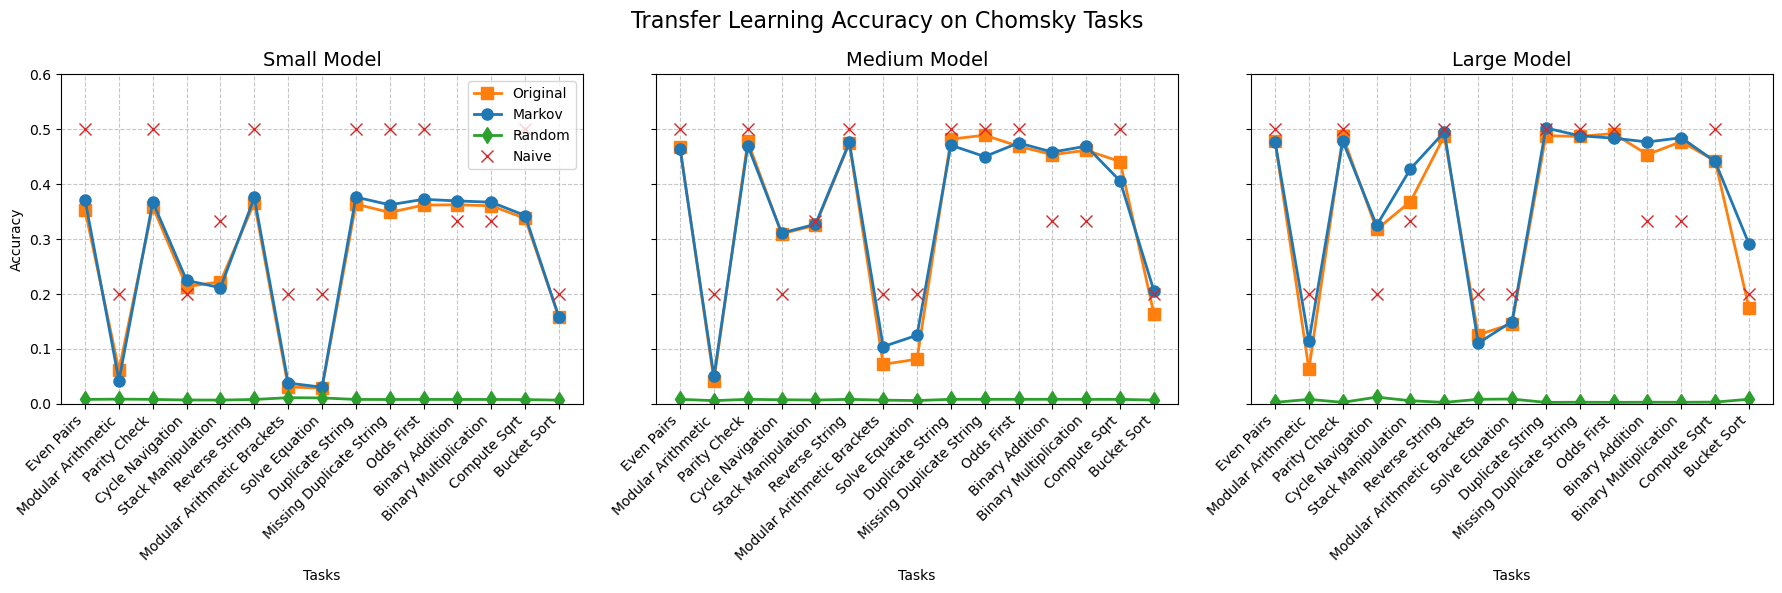

In [3]:
# Load the Chomsky results
with open('artifacts/chomsky_results.json', 'r') as f:
    chomsky_results = json.load(f)

model_types = ["original", "markov", "random", "naive"] # "baseline"
model_sizes = ["small", "medium", "large"]  # Adjust order if desired
tasks = [
    "even_pairs",
    "modular_arithmetic",
    "parity_check",
    "cycle_navigation",
    "stack_manipulation",
    "reverse_string",
    "modular_arithmetic_brackets",
    "solve_equation",
    "duplicate_string",
    "missing_duplicate_string",
    "odds_first",
    "binary_addition",
    "binary_multiplication",
    "compute_sqrt",
    "bucket_sort",
]

# This is the accuracy if we just randomly predict the next token (from the set of allowable tokens)
naive_accuracy_map = {
    "even_pairs": 1/2,
    "modular_arithmetic": 1/5,
    "parity_check": 1/2,
    "cycle_navigation": 1/5,
    "stack_manipulation": 1/3,
    "reverse_string": 1/2,
    "modular_arithmetic_brackets": 1/5,
    "solve_equation": 1/5,
    "duplicate_string": 1/2,
    "missing_duplicate_string": 1/2,
    "odds_first": 1/2,
    "binary_addition": 1/3,
    "binary_multiplication": 1/3,
    "compute_sqrt": 1/2,
    "bucket_sort": 1/5,
}

# Prepare x-axis
x = np.arange(len(tasks))

# Create one row with three subplots for small, medium, large
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)
fig.suptitle("Transfer Learning Accuracy on Chomsky Tasks", fontsize=16)

# For consistent coloring/markers for each model_type, define them here
type_styles = {
    "markov":    {"color": "C0", "marker": "o"},
    "original":  {"color": "C1", "marker": "s"},
    "random":  {"color": "C2", "marker": "d"},
    "naive":  {"color": "C3", "marker": "x"},
}

# Iterate over model sizes and subplots
for i, model_size in enumerate(model_sizes):
    ax = axs[i]

    # Plot each model type on the current subplot
    for model_type in model_types:
        if model_type == "naive":
            accuracies = list(naive_accuracy_map.values())
            
            # Plot the accuracy of naive predictor
            style = type_styles.get(model_type, {})
            ax.plot(
                x,
                accuracies,
                label=model_type.capitalize(),
                linestyle="None",
                markersize=8,
                **style
            )
            continue

        # Construct the key used in chomsky_results
        model_key = f"artifacts/params_{model_type}_transformer_{model_size}.npz"
        if model_key in chomsky_results:
            # Collect accuracies for each task
            accuracies = []
            for task in tasks:
                if task in chomsky_results[model_key]:
                    accuracies.append(chomsky_results[model_key][task]["total_accuracy"])
                else:
                    accuracies.append(0.0)  # or np.nan, etc.
            
            # Plot the accuracy curve for this model_type
            style = type_styles.get(model_type, {})
            ax.plot(
                x,
                accuracies,
                label=model_type.capitalize(),
                linewidth=2,
                markersize=8,
                **style
            )
        else:
            raise ValueError(f"No data found for {model_key}, skipping plot.")

    # Format the subplot
    ax.set_title(f"{model_size.capitalize()} Model", fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([t.replace('_', ' ').title() for t in tasks], rotation=45, ha='right')
    ax.set_xlabel("Tasks")
    ax.set_ylim(0, 0.6)  # Set y-axis limits from 0 to 1
    ax.grid(True, linestyle="--", alpha=0.7)

# Share the Y-axis label across subplots
axs[0].set_ylabel("Accuracy")

# Put a legend on the first (or any) subplot.
# Alternatively, use a single legend for all subplots with fig.legend(...)
axs[0].legend(loc="best")

plt.tight_layout()
plt.show()

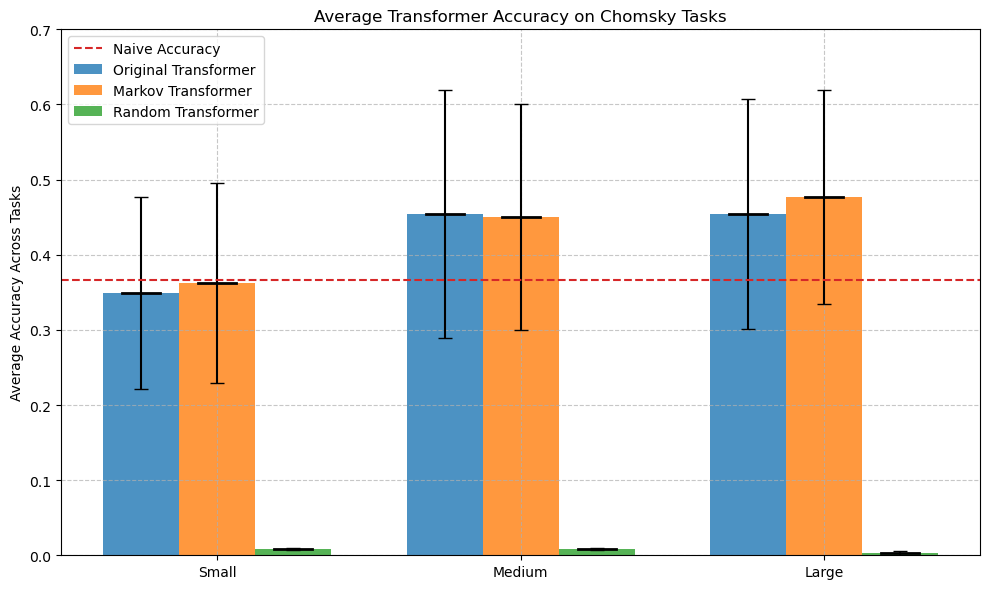

In [4]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate average accuracies for each model type and size
avg_accuracies = {}
for model_type in model_types:
    avg_accuracies[model_type] = {}
    for size in model_sizes:
        model_key = f"artifacts/params_{model_type}_transformer_{size}.npz"
        if model_key in chomsky_results:
            # Collect accuracies for all tasks for this model
            task_accuracies = []
            for task in tasks:
                if task in chomsky_results[model_key]:
                    task_accuracies.append(chomsky_results[model_key][task]["total_accuracy"])
            
            # Calculate mean, median, and std dev
            avg_accuracies[model_type][size] = {
                'mean': np.mean(task_accuracies),
                'median': np.median(task_accuracies),
                'std': np.std(task_accuracies)
            }

# X-coordinates for the bars
x = np.arange(len(model_sizes))
bar_width = 0.25  # Width of bars, narrower to fit both model types

# Colors for each model type
colors = {'original': 'C0', 'markov': 'C1', 'random': 'C2', 'naive': 'C3'}

# Plot bars for each model type
for i, model_type in enumerate(model_types):
    if model_type == "naive":
        continue
    means = [avg_accuracies[model_type][size]['mean'] for size in model_sizes]
    stds = [avg_accuracies[model_type][size]['std'] for size in model_sizes]
    medians = [avg_accuracies[model_type][size]['median'] for size in model_sizes]
    
    # Position bars side by side
    pos = x + (i - 1) * bar_width
    
    # Plot bars with error bars
    bars = ax.bar(
        pos, medians, 
        yerr=stds, 
        width=bar_width, 
        color=colors[model_type],
        alpha=0.8, 
        capsize=5, 
        label=f'{model_type.capitalize()} Transformer'
    )
    
    # Overlay median lines
    for j, median in enumerate(medians):
        ax.plot(
            [pos[j] - bar_width/4, pos[j] + bar_width/4],
            [median, median],
            color='k', linewidth=2, label='_nolegend_'
        )

avg_naive_accuracy = np.mean(list(naive_accuracy_map.values()))
ax.axhline(y=avg_naive_accuracy, linestyle='--', label='Naive Accuracy', color=colors['naive'])

# Style the axes
ax.set_xticks(x)
ax.set_xticklabels([size.capitalize() for size in model_sizes])
ax.set_ylim([0, 0.7])  # Adjust as needed based on actual data
ax.set_ylabel('Average Accuracy Across Tasks')
ax.set_title('Average Transformer Accuracy on Chomsky Tasks')
ax.grid(True, linestyle='--', alpha=0.7)

# Show legend
ax.legend()

plt.tight_layout()
plt.show()